In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt

from os.path import join

from scipy.stats import fligner
from nilearn import plotting, datasets, surface

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
sns.set(style='whitegrid', context='talk')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier New'

In [3]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [5]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data.csv"), index_col=0, header=0)

In [6]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [7]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [8]:
tests = ['variance', 
         'fligner_sex',
         'fligner_puberty_m',
         'fligner_puberty_f',
         'fligner_puberty_1',
         'fligner_puberty_2',
         'fligner_puberty_3',
         'fligner_puberty_4',
         'fligner_puberty_5',
         'fligner_raceth', 
         'fligner_income', 
         'fligner_edu', 
         'fligner_marital', 
         'fligner_age', 
         'fligner_scanner']
alpha = 0.05
values = ['stat', 'p', 'diff', 'greater', f'a<{alpha}']
columns = pd.MultiIndex.from_product([tests, values])

var_df = pd.DataFrame(columns=columns)

In [9]:
age_bins = np.zeros((10,))
for percentile in range(0, 100, 10):
    index = int(percentile / 10)
    age_bins[index] = np.percentile(df['interview_age.baseline_year_1_arm_1'], 
                                    float(percentile))

In [10]:
img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

In [11]:
for modality in img_modalities.keys():
    variables = img_modalities[modality].columns
    for var in variables:
        # compute variance across the sample
        var_df.at[var, ('variance', 'stat')] = np.var(df[var])
        
        # compare variance between male and female participants
        m = df[df['sex.baseline_year_1_arm_1'] == 'M'][var].dropna()
        f = df[df['sex.baseline_year_1_arm_1'] == 'F'][var].dropna()
        test = fligner(m, f)
        var_df.at[var, ('fligner_sex', 'stat')] = test[0]
        var_df.at[var, ('fligner_sex', 'p')] = test[1]
        var_df.at[var, ('fligner_sex', 'diff')] = np.mean(f) - np.mean(m)
        var_df.at[var, ('fligner_sex', 'greater')] = 'f'
        if test[1] < alpha:
            var_df.at[var, ('fligner_sex', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_sex', f'a<{alpha}')] = 'ns'
        
        # compare variance between pubertal stages at baseline, female ppts
        puberty = 'pds_p_ss_female_category_2.baseline_year_1_arm_1'
        one = df[df[puberty] == 1.][var].dropna()
        two = df[df[puberty] == 2.][var].dropna()
        three = df[df[puberty] == 3.][var].dropna()
        test = fligner(one, two, three)
        var_df.at[var, ('fligner_puberty_f', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_f', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_puberty_f', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_puberty_f', f'a<{alpha}')] = 'ns'
        
        var_dict = {'1': np.mean(one), 
                    '2': np.mean(two), 
                    '3': np.mean(three)}
        max_key = max(var_dict, key=var_dict.get)
        min_val = min(var_dict.values())
        sorted_keys = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1])}
        var_df.at[var, ('fligner_puberty_f', 'diff')] = var_dict[max_key] - min_val
        var_df.at[var, ('fligner_puberty_f', 'greater')] = [list(sorted_keys.keys())]
        
        # compare variance between pubertal stages at baseline, male ppts
        puberty = 'pds_p_ss_male_category_2.baseline_year_1_arm_1'
        one = df[df[puberty] == 1.][var].dropna()
        two = df[df[puberty] == 2.][var].dropna()
        three = df[df[puberty] == 3.][var].dropna()
        test = fligner(one, two, three)
        var_dict = {'1': np.mean(one), 
                    '2': np.mean(two), 
                    '3': np.mean(three)}
        max_key = max(var_dict, key=var_dict.get)
        min_val = min(var_dict.values())
        sorted_keys = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1])}
        var_df.at[var, ('fligner_puberty_m', 'diff')] = var_dict[max_key] - min_val
        var_df.at[var, ('fligner_puberty_m', 'greater')] = [list(sorted_keys.keys())]
        var_df.at[var, ('fligner_puberty_m', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_m', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_puberty_m', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_puberty_m', f'a<{alpha}')] = 'ns'
        
        # compare variance between sexes at baseline, pubertal stages
        puberty_f = 'pds_p_ss_female_category_2.baseline_year_1_arm_1'
        puberty_m = 'pds_p_ss_male_category_2.baseline_year_1_arm_1'
        one_f = df[df[puberty_f] == 1.][var].dropna()
        two_f = df[df[puberty_f] == 2.][var].dropna()
        three_f = df[df[puberty_f] == 3.][var].dropna()
        one_m = df[df[puberty_m] == 1.][var].dropna()
        two_m = df[df[puberty_m] == 2.][var].dropna()
        three_m = df[df[puberty_m] == 3.][var].dropna()
        test = fligner(one_f, one_m)
        var_df.at[var, ('fligner_puberty_1', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_1', 'p')] = test[1]
        var_df.at[var, ('fligner_puberty_1', 'diff')] = np.mean(one_f) - np.mean(one_m)
        var_df.at[var, ('fligner_puberty_1', 'greater')] = 'f'
        if test[1] < alpha:
            var_df.at[var, ('fligner_puberty_1', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_puberty_1', f'a<{alpha}')] = 'ns'
        test = fligner(two_f, two_m)
        var_df.at[var, ('fligner_puberty_2', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_2', 'p')] = test[1]
        var_df.at[var, ('fligner_puberty_2', 'diff')] = np.mean(two_f) - np.mean(two_m)
        var_df.at[var, ('fligner_puberty_2', 'greater')] = 'f'
        if test[1] < alpha:
            var_df.at[var, ('fligner_puberty_2', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_puberty_2', f'a<{alpha}')] = 'ns'
        test = fligner(three_f, three_m)
        var_df.at[var, ('fligner_puberty_3', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty_3', 'p')] = test[1]
        var_df.at[var, ('fligner_puberty_3', 'diff')] = np.mean(three_f) - np.mean(three_m)
        var_df.at[var, ('fligner_puberty_3', 'greater')] = 'f'
        if test[1] < alpha:
            var_df.at[var, ('fligner_puberty_3', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_puberty_3', f'a<{alpha}')] = 'ns'
        
        #compare variance across race/ethnicities
        race = 'race_ethnicity.baseline_year_1_arm_1'
        white = df[df[race] == 1.][var].dropna()
        black = df[df[race] == 2.][var].dropna()
        hispanic = df[df[race] == 3.][var].dropna()
        asian = df[df[race] == 4.][var].dropna()
        other = df[df[race] == 5.][var].dropna()
        test = fligner(white, black, hispanic, asian, other)
        var_df.at[var, ('fligner_raceth', 'stat')] = test[0]
        var_df.at[var, ('fligner_raceth', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_raceth', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_raceth', f'a<{alpha}')] = 'ns'
        
        # compare variance across income
        income = 'demo_comb_income_v2.baseline_year_1_arm_1'
        lt50k = df[df[income] < 6.][var].dropna()
        lt100 = df[df[income].between(6., 8.)][var].dropna()
        gt100 = df[df[income].between(9., 10.)][var].dropna()
        
        test = fligner(lt50k, lt100, gt100)
        var_df.at[var, ('fligner_income', 'stat')] = test[0]
        var_df.at[var, ('fligner_income', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_income', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_income', f'a<{alpha}')] = 'ns'
        
        # compare variance across education
        edu = 'demo_prnt_ed_v2.baseline_year_1_arm_1'
        one = df[df[edu] == 1][var].dropna()
        two = df[df[edu] == 2][var].dropna()
        three = df[df[edu] == 3][var].dropna()
        four = df[df[edu] == 4][var].dropna()
        five = df[df[edu] == 5][var].dropna()
        six = df[df[edu] == 6][var].dropna()
        seven = df[df[edu] == 7][var].dropna()
        eight = df[df[edu] == 8][var].dropna()
        nine = df[df[edu] == 9][var].dropna()
        ten = df[df[edu] == 10][var].dropna()
        eleven = df[df[edu] == 11][var].dropna()
        twelve = df[df[edu] == 12][var].dropna()
        thirteen = df[df[edu] == 13][var].dropna()
        fourteen = df[df[edu] == 14][var].dropna()
        fifteen = df[df[edu] == 15][var].dropna()
        sixteen = df[df[edu] == 16][var].dropna()
        seventeen = df[df[edu] == 17][var].dropna()
        eighteen = df[df[edu] == 18][var].dropna()
        nineteen = df[df[edu] == 19][var].dropna()
        twenty = df[df[edu] == 20][var].dropna()
        twentyone = df[df[edu] == 21][var].dropna()
        sevens = df[df[edu] == 777][var].dropna()
        test = fligner(one, two, three, four, five, six, 
                      seven, eight, nine, ten, sevens, 
                      eleven, twelve, thirteen, fourteen, fifteen,
                      sixteen, seventeen, eighteen, nineteen, twenty, twentyone)
        var_df.at[var, ('fligner_edu', 'stat')] = test[0]
        var_df.at[var, ('fligner_edu', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_edu', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_edu', f'a<{alpha}')] = 'ns'
        
        # compare variance across age, binned by n0th percentiles
        # age_bins are calculated above
        age = 'interview_age.baseline_year_1_arm_1'
        one = df[df[age] < age_bins[1]][var].dropna()
        two = df[df[age].between(age_bins[1], age_bins[2] - 1)][var].dropna()
        three = df[df[age].between(age_bins[2], age_bins[3] - 1.)][var].dropna()
        four = df[df[age].between(age_bins[3], age_bins[4] - 1.)][var].dropna()
        five = df[df[age].between(age_bins[4], age_bins[5] - 1.)][var].dropna()
        six = df[df[age].between(age_bins[5], age_bins[6] - 1.)][var].dropna()
        seven = df[df[age].between(age_bins[6], age_bins[7] - 1.)][var].dropna()
        eight = df[df[age].between(age_bins[7], age_bins[8] - 1.)][var].dropna()
        nine = df[df[age].between(age_bins[8], age_bins[9] - 1.)][var].dropna()
        ten = df[df[age] >= age_bins[9]][var].dropna()
                 
        test = fligner(one, two, three, four, five, six, 
                      seven, eight, nine, ten)
        var_df.at[var, ('fligner_age', 'stat')] = test[0]
        var_df.at[var, ('fligner_age', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_age', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_age', f'a<{alpha}')] = 'ns'
        
         # compare variance across scanner manufacturers
        mri = 'mri_info_manufacturer.baseline_year_1_arm_1'
        siemens = df[df[mri] == 'SIEMENS'][var].dropna()
        ge = df[df[mri] == 'GE MEDICAL SYSTEMS'][var].dropna()
        philips = df[df[mri] == 'Philips Medical Systems'][var].dropna()
        
        test = fligner(siemens, philips, ge)
        var_df.at[var, ('fligner_scanner', 'stat')] = test[0]
        var_df.at[var, ('fligner_scanner', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_scanner', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_scanner', f'a<{alpha}')] = 'ns'
        
        # compare variance across parent marital status
        marry = "demo_prnt_marital_v2.baseline_year_1_arm_1"
        married = df[df[marry] == 1.][var].dropna()
        widowed = df[df[marry] == 2.][var].dropna()
        divorced = df[df[marry] == 3.][var].dropna()
        separated = df[df[marry] == 4.][var].dropna()
        never = df[df[marry] == 5.][var].dropna()
        refuse = df[df[marry] == 777.][var].dropna()
        
        test = fligner(married, widowed, separated, divorced, never, refuse)
        var_df.at[var, ('fligner_marital', 'stat')] = test[0]
        var_df.at[var, ('fligner_marital', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_marital', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_marital', f'a<{alpha}')] = 'ns'

In [12]:
var_df

variance                           \
                                               stat    p diff greater a<0.05   
smri_vol_scs_intracranialv.change_score    1.581418  NaN  NaN     NaN    NaN   
smri_vol_cdk_total.change_score            1.316309  NaN  NaN     NaN    NaN   
smri_area_cdk_banksstslh.change_score      8.202061  NaN  NaN     NaN    NaN   
smri_area_cdk_cdacatelh.change_score       7.183843  NaN  NaN     NaN    NaN   
smri_area_cdk_cdmdfrlh.change_score        8.005432  NaN  NaN     NaN    NaN   
...                                             ...  ...  ...     ...    ...   
dmri_dtivol_fiberat_sifclh.change_score    9.545437  NaN  NaN     NaN    NaN   
dmri_dtivol_fiberat_ifsfcrh.change_score   4.564034  NaN  NaN     NaN    NaN   
dmri_dtivol_fiberat_ifsfclh.change_score   6.622358  NaN  NaN     NaN    NaN   
dmri_dtivol_fiberat_fxcutrh.change_score  15.667113  NaN  NaN     NaN    NaN   
dmri_dtivol_fiberat_fxcutlh.change_score  16.252235  NaN  NaN     NaN    NaN   

                                         fligner_sex                      \
                                                stat         p      diff   
smri_vol_scs_intracranialv.change_score     37.34447       0.0  0.081282   
smri_vol_cdk_total.change_score            27.431595       0.0 -0.314164   
smri_area_cdk_banksstslh.change_score       1.768325   0.18359 -0.392274   
smri_area_cdk_cdacatelh.change_score        0.048548  0.825609 -0.156068   
smri_area_cdk_cdmdfrlh.change_score         0.046386  0.829475 -0.248972   
...                                              ...       ...       ...   
dmri_dtivol_fiberat_sifclh.change_score     1.121887  0.289512 -0.018292   
dmri_dtivol_fiberat_ifsfcrh.change_score    5.528232  0.018712  0.290483   
dmri_dtivol_fiberat_ifsfclh.change_score   15.862649  0.000068  0.229797   
dmri_dtivol_fiberat_fxcutrh.change_score    1.535585  0.215276 -0.002509   
dmri_dtivol_fiberat_fxcutlh.change_score    1.567314  0.210597 -0.002932   

                                                         ... fligner_age  \
                                         greater a<0.05  ...        stat   
smri_vol_scs_intracranialv.change_score        f     **  ...    59.51885   
smri_vol_cdk_total.change_score                f     **  ...   29.325156   
smri_area_cdk_banksstslh.change_score          f     ns  ...   20.753963   
smri_area_cdk_cdacatelh.change_score           f     ns  ...      9.9598   
smri_area_cdk_cdmdfrlh.change_score            f     ns  ...   23.842737   
...                                          ...    ...  ...         ...   
dmri_dtivol_fiberat_sifclh.change_score        f     ns  ...    5.468687   
dmri_dtivol_fiberat_ifsfcrh.change_score       f     **  ...    8.004934   
dmri_dtivol_fiberat_ifsfclh.change_score       f     **  ...    3.837368   
dmri_dtivol_fiberat_fxcutrh.change_score       f     ns  ...    13.33325   
dmri_dtivol_fiberat_fxcutlh.change_score       f     ns  ...    6.626252   

                                                                        \
                                                 p diff greater a<0.05   
smri_vol_scs_intracranialv.change_score        0.0  NaN     NaN     **   
smri_vol_cdk_total.change_score           0.000571  NaN     NaN     **   
smri_area_cdk_banksstslh.change_score     0.013789  NaN     NaN     **   
smri_area_cdk_cdacatelh.change_score      0.353749  NaN     NaN     ns   
smri_area_cdk_cdmdfrlh.change_score       0.004557  NaN     NaN     **   
...                                            ...  ...     ...    ...   
dmri_dtivol_fiberat_sifclh.change_score   0.791689  NaN     NaN     ns   
dmri_dtivol_fiberat_ifsfcrh.change_score  0.533649  NaN     NaN     ns   
dmri_dtivol_fiberat_ifsfclh.change_score  0.921787  NaN     NaN     ns   
dmri_dtivol_fiberat_fxcutrh.change_score  0.148098  NaN     NaN     ns   
dmri_dtivol_fiberat_fxcutlh.change_score  0.675968  NaN     NaN     ns   

                                         fligner_scanner     

In [13]:
var_df.dropna(how='all', axis=1, inplace=True)

In [20]:
# calculate what proportion of measures show significant heteroscedasticity
# just count('**') / 1776 measures
var_df.to_csv(join(PROJ_DIR, OUTP_DIR, 'variance_flinger.csv'))

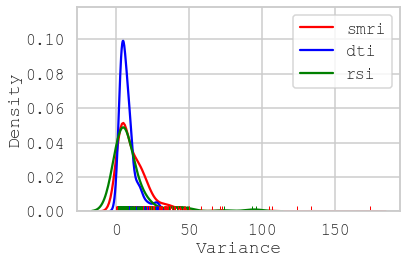

In [24]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
fmri_var = img_modalities['fmri'].columns

fig,ax = plt.subplots()
g = sns.kdeplot(var_df.loc[smri_var, ('variance', 'stat')], color='red')
h = sns.kdeplot(var_df.loc[dti_var, ('variance', 'stat')], color='blue')
i = sns.kdeplot(var_df.loc[rsi_var, ('variance', 'stat')], color='green')
#m = sns.kdeplot(var_df.loc[fmri_var, ('variance', 'stat')], color='orange')
j = sns.rugplot(var_df.loc[smri_var, ('variance', 'stat')], color='red')
k = sns.rugplot(var_df.loc[dti_var, ('variance', 'stat')], color='blue')
l = sns.rugplot(var_df.loc[rsi_var, ('variance', 'stat')], color='green')
#n = sns.rugplot(var_df.loc[fmri_var, ('variance', 'stat')], color='orange')
ax.set_xlabel('Variance')
plt.tight_layout()
ax.legend(['smri', 
           'dti', 
           'rsi', 
           #'fmri'
          ])
fig.savefig('../figures/variance_nofmri.png', dpi=400)
#sns.displot(var_df.loc[fmri_var, ('variance', 'stat')])

In [25]:
sex_diff = {}
for modality in img_modalities.keys():
    variables = img_modalities[modality].columns
    sex_diff[modality] = np.sum(var_df.loc[variables][('fligner_sex', 'p')] < 0.01) / len(variables)

In [26]:
sex_diff

{'smri': 0.1910828025477707,
 'fmri': 0.11213720316622691,
 'rsi': 0.040983606557377046,
 'dti': 0.16216216216216217}

## Visualizing brain heterogeneity across non-brain variables
1. Variability across all brain measures
2. Per modality
3. Across the brain
4. Across developmental variables
5. Across demographic variables

In [27]:
for var in var_df.index:
    for modality in img_modalities.keys():
        if var in img_modalities[modality]:
            var_df.at[var, 'modality'] = modality

In [29]:
var_df[var_df['modality'] == 'fmri'][('variance', 'stat')].sort_values()

rsfmri_c_ngd_ca_ngd_ca.change_score              155.95812
rsfmri_c_ngd_cgc_ngd_cgc.change_score           170.853194
rsfmri_c_ngd_dt_ngd_dt.change_score             175.487514
rsfmri_c_ngd_vs_ngd_vs.change_score             177.021058
rsfmri_c_ngd_rspltp_ngd_rspltp.change_score      179.58422
                                                  ...     
rsfmri_cor_ngd_none_scs_bs.change_score        2742.079965
rsfmri_cor_ngd_df_scs_thplh.change_score       2745.036297
rsfmri_cor_ngd_fopa_scs_crcxrh.change_score    2752.969579
rsfmri_cor_ngd_vs_scs_aalh.change_score        2764.342993
rsfmri_cor_ngd_vta_scs_cderh.change_score      2772.300771
Name: (variance, stat), Length: 758, dtype: object

<AxesSubplot:xlabel="('variance', 'stat')", ylabel='Density'>

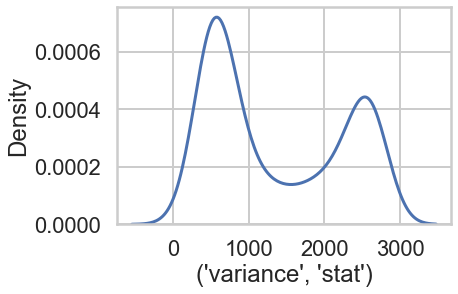

In [103]:
sns.kdeplot(var_df[var_df['modality'] == 'fmri'][('variance', 'stat')])

In [30]:
devt = ['fligner_age', 
        'fligner_sex',
        'fligner_puberty_f',
        'fligner_puberty_m',
        'fligner_puberty_1',
        'fligner_puberty_2',
        'fligner_puberty_3']
demo =  ['fligner_raceth',
         'fligner_income',
         'fligner_edu',
         'fligner_marital', 
         'fligner_scanner'
        ]

In [31]:
stats = var_df.drop(['variance'], axis=1).xs('stat', level=1, axis=1)
alphas = var_df.xs(f'a<{alpha}', level=1, axis=1)
modalities = var_df['modality']

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [32]:
mod_demo = pd.concat([stats[demo], 
                      modalities], 
                     axis=1).melt(value_name='Flinger-Killeen Statistic', 
                                  id_vars='modality')
mod_devt = pd.concat([stats[devt], 
                      modalities], 
                     axis=1).melt(value_name='Flinger-Killeen Statistic', 
                                  id_vars='modality')

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/2739423015.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


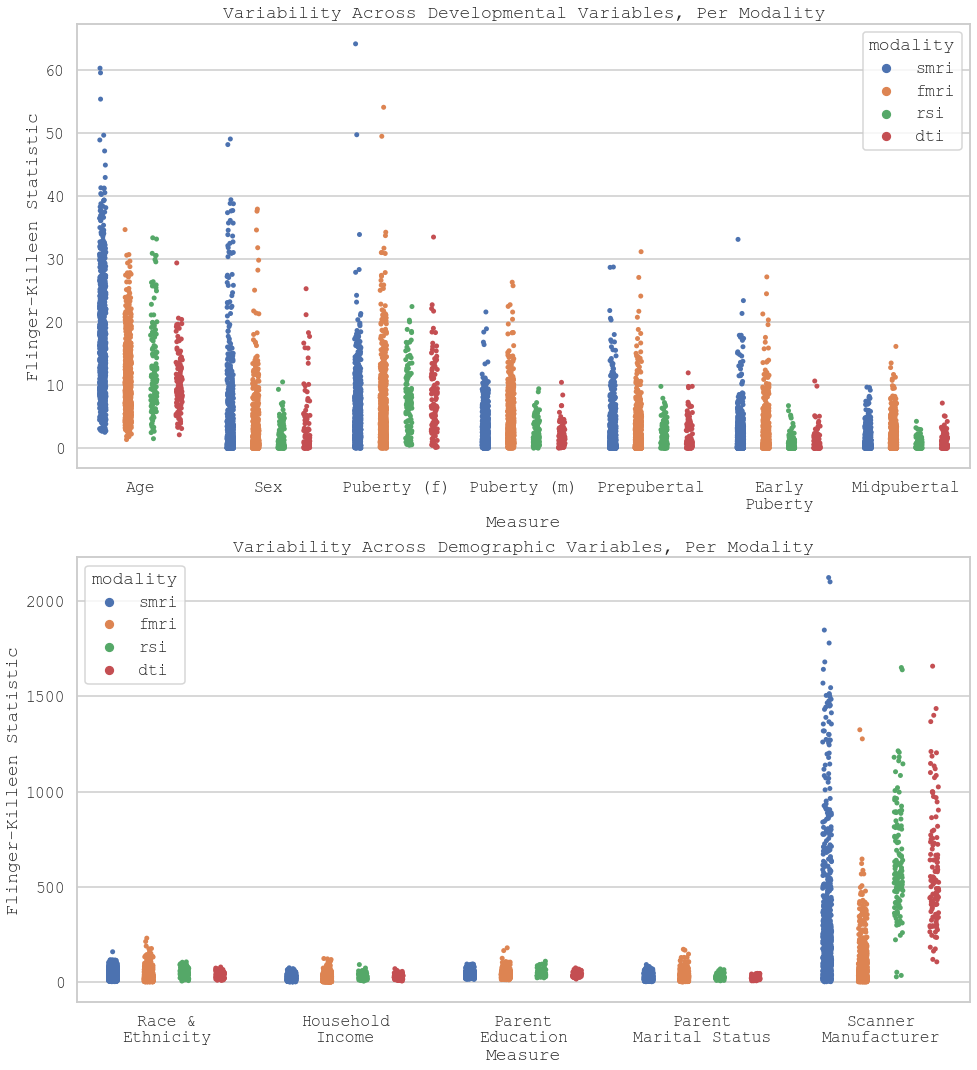

In [33]:
fig,ax = plt.subplots(nrows=2, figsize=(16,18))
g = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=mod_devt, 
                  hue='modality',
                  dodge=True,
                  ax=ax[0]
                 )
g.set_ylabel('Flinger-Killeen Statistic')
g.set_xlabel('Measure')
g.set_xticklabels(['Age', 'Sex', 'Puberty (f)', 'Puberty (m)', 'Prepubertal', 'Early\nPuberty', 'Midpubertal'])
g.set_title('Variability Across Developmental Variables, Per Modality')

h = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=mod_demo, 
                  hue='modality',
                  dodge=True,
                  ax=ax[1]
                 )
h.set_ylabel('Flinger-Killeen Statistic')
h.set_xlabel('Measure')
h.set_title('Variability Across Demographic Variables, Per Modality')
h.set_xticklabels(['Race &\nEthnicity', 
                   'Household\nIncome', 
                   'Parent\nEducation', 
                   'Parent\nMarital Status', 
                   'Scanner\nManufacturer'
                  ])
fig.show()
fig.savefig('../figures/heteroscedasticity_modality.png', dpi=400)

In [34]:
fk_df = pd.concat([stats[devt].melt(value_name='Flinger-Killeen Statistic'), 
                   alphas[devt].melt(value_name='Significant').drop('variable', axis=1)], axis=1)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1984893869.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


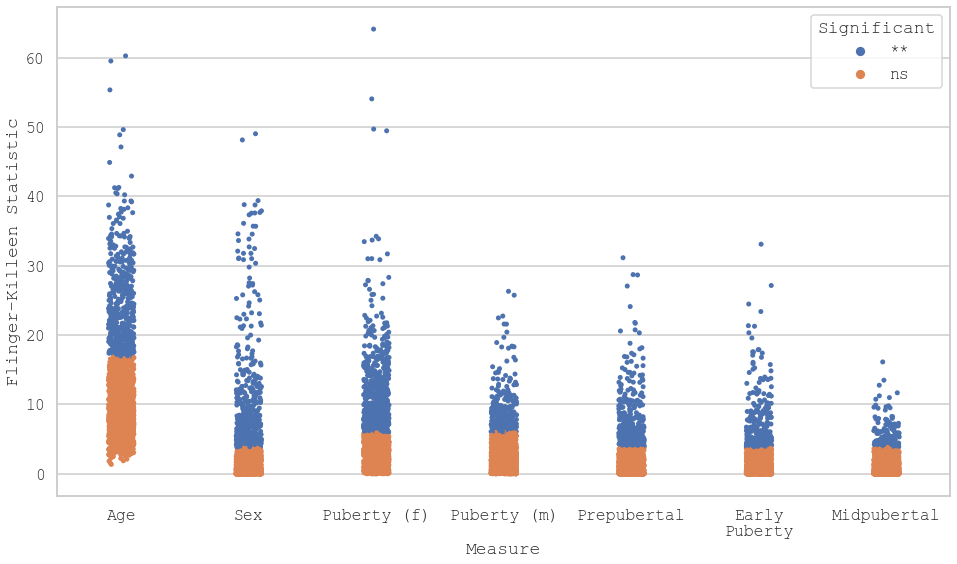

In [35]:
fig,ax = plt.subplots(figsize=(16,9))
g = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=fk_df, 
                  hue='Significant'
                 )
g.set_ylabel('Flinger-Killeen Statistic')
g.set_xlabel('Measure')
g.set_xticklabels(['Age', 'Sex', 'Puberty (f)', 'Puberty (m)', 'Prepubertal', 'Early\nPuberty', 'Midpubertal'])
fig.show()
fig.savefig('../figures/heteroscedasticity_development.png', dpi=400)

In [36]:
fk_df = pd.concat([stats[demo].melt(value_name='Flinger-Killeen Statistic'), 
                   alphas[demo].melt(value_name='Significant').drop('variable', axis=1)], axis=1)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/3242337330.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


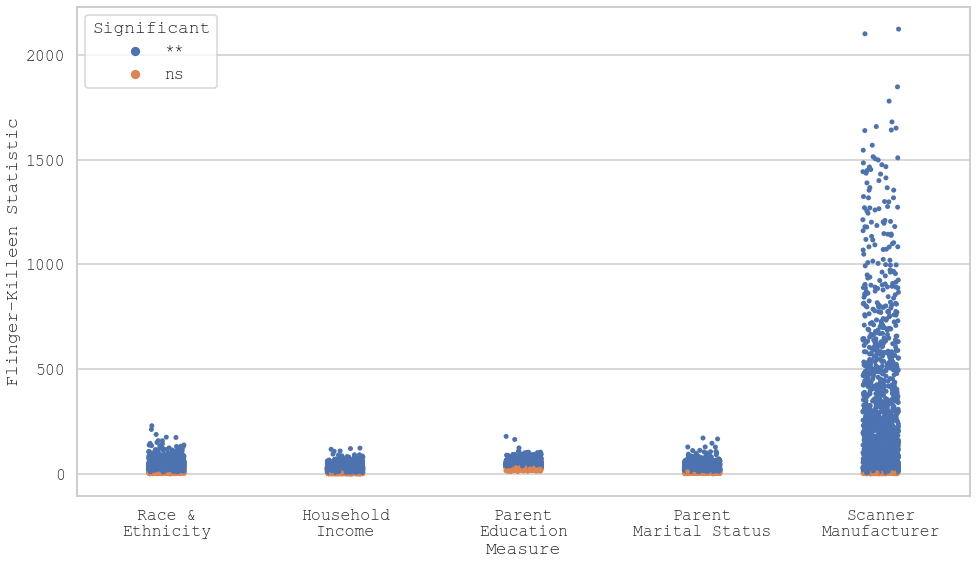

In [37]:
fig,ax = plt.subplots(figsize=(16,9))
g = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=fk_df, 
                  hue='modality'
                 )
g.set_ylabel('Flinger-Killeen Statistic')
g.set_xlabel('Measure')
g.set_xticklabels(['Race &\nEthnicity', 
                   'Household\nIncome', 
                   'Parent\nEducation', 
                   'Parent\nMarital Status', 
                   'Scanner\nManufacturer'
                  ])
fig.show()
fig.savefig('../figures/heteroscedasticity_demographics.png', dpi=400)

In [38]:
# let's visualize this variability!
destrieux = datasets.fetch_atlas_surf_destrieux()
desikan = datasets.fetch_neurovault_ids(image_ids=(23262, ))

Reading local neurovault data.
Already fetched 1 image
1 image found on local disk.


In [39]:
atlas_to_abcd_thick = pd.DataFrame(columns=['label', 'abcd_var'])
l_and_r_destrieux = destrieux.labels * 2
for i in range(0, len(l_and_r_destrieux)):
    atlas_to_abcd_thick.at[i,'label'] = l_and_r_destrieux[i]
    if i == 0:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif i < 42:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i}'
    elif i == 42:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif 42 < i < 76:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i - 1}'
    elif i == 76:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif 76 < i < 116:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i - 2}'
    elif i == 116:
        atlas_to_abcd_thick.at[i,'abcd_var'] = np.nan
    elif i > 116:
        atlas_to_abcd_thick.at[i,'abcd_var'] = f'mrisdp_{i - 3}'

In [40]:
atlas_to_abcd_area = pd.DataFrame(columns=['label', 'abcd_var'])
l_and_r_destrieux = destrieux.labels * 2
for i in range(0, len(l_and_r_destrieux)):
    atlas_to_abcd_area.at[i,'label'] = l_and_r_destrieux[i]
    if i == 0:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif i < 42:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i+302}'
    elif i == 42:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif 42 < i < 76:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i + 301}'
    elif i == 76:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif 76 < i < 116:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i + 300}'
    elif i == 116:
        atlas_to_abcd_area.at[i,'abcd_var'] = np.nan
    elif i > 116:
        atlas_to_abcd_area.at[i,'abcd_var'] = f'mrisdp_{i + 299}'

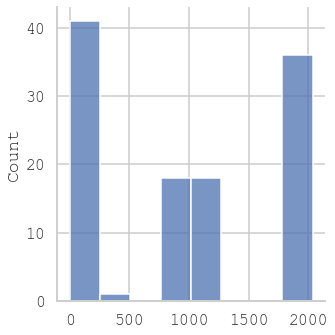

In [41]:
# plot variance on a brain!
desikan_vol_nimg = nib.load(desikan.images[0])
desikan_vol_arra = desikan_vol_nimg.get_fdata()
sns.displot(np.unique(desikan_vol_arra))

In [42]:
desikan

{'images': ['/Users/katherine.b/nilearn_data/neurovault/collection_1446/image_23262.nii.gz'],
 'images_meta': [{'url': 'https://neurovault.org/images/23262/',
   'id': 23262,
   'file': 'https://neurovault.org/media/images/1446/aparcaseg.nii.gz',
   'collection': 'https://neurovault.org/collections/1446/',
   'collection_id': 1446,
   'file_size': 333787,
   'cognitive_paradigm_cogatlas': None,
   'cognitive_paradigm_cogatlas_id': None,
   'cognitive_contrast_cogatlas': None,
   'cognitive_contrast_cogatlas_id': None,
   'map_type': 'parcellation',
   'analysis_level': 'group',
   'name': 'Desikan-Killiany Atlas',
   'description': None,
   'add_date': '2016-06-09T16:03:13.421197Z',
   'modify_date': '2018-06-30T05:05:03.356811Z',
   'is_valid': True,
   'surface_left_file': 'https://neurovault.org/media/images/1446/23262.L.func.gii',
   'surface_right_file': 'https://neurovault.org/media/images/1446/23262.R.func.gii',
   'data_origin': 'volume',
   'target_template_image': 'GenericMNI

In [43]:
subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')

In [44]:
scs = [np.nan,
       np.nan,
       np.nan,
       np.nan,
       "tplh",
       "cdlh",
       "ptlh",
       "pllh",
       "bs",
       "hclh",
       "aglh",
       "ablh",
       np.nan,
       np.nan,
       np.nan,
       "tprh",
       "cdrh",
       "ptrh",
       "plrh",
       "hcrh",
       "agrh",
       "abrh",
       np.nan]

In [45]:
scs_1 = ['x',
         'x',
         'x',
         'x',
        "tplh",
        "caudatelh",
        "putamenlh",
        "pallidumlh",
        "bstem",
        "hpuslh",
        "amygdalalh",
        "aal",
        'x',
        'x',
         'x',
        "tprh",
        "caudaterh",
        "putamenrh",
        "pallidumrh",
        "hpusrh",
        "amygdalarh",
        "aar"]

In [46]:
abcd_to_harvox = pd.DataFrame(columns=['label', 'Volume', 
                                       'T1w Intensity', 
                                       'Restricted Normalized Directional Diffusion', 
                                       'Restricted Normalized Isotropic Diffusion'])

for i in range(0, len(subcort.labels)):
    label = subcort.labels[i]
    abcd_to_harvox.at[i, 'label'] = label
    if scs_1[i] == 'x':
        abcd_to_harvox.at[i, 'Volume'] = np.nan
        abcd_to_harvox.at[i, 'T1w Intensity'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = np.nan
    else:
        abcd_to_harvox.at[i, 'Volume'] = f'smri_vol_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'T1w Intensity'] = f'smri_t1w_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = f'dmri_rsirnd_scs_{scs[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = f'dmri_rsirni_scs_{scs[i]}'

In [47]:
plotted_vars = []

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


<Figure size 432x288 with 0 Axes>

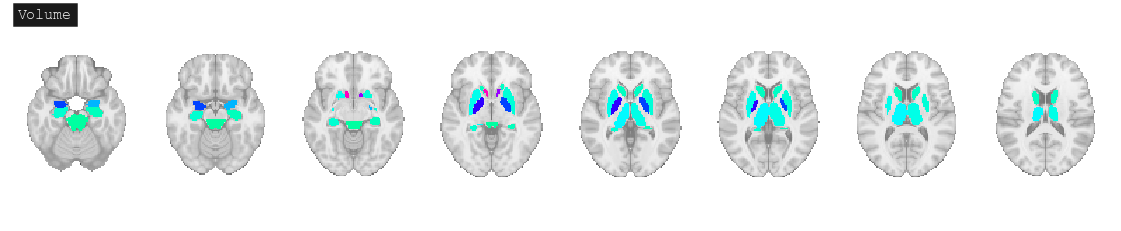

<Figure size 432x288 with 0 Axes>

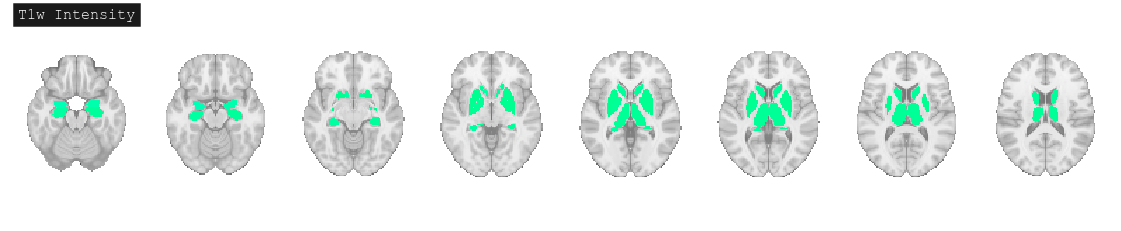

<Figure size 432x288 with 0 Axes>

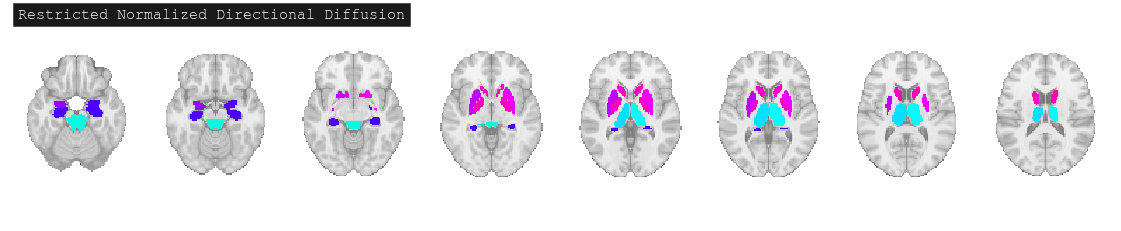

<Figure size 432x288 with 0 Axes>

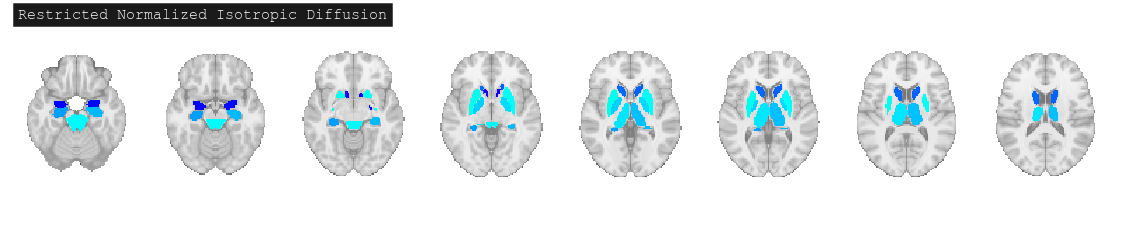

In [48]:
sc_array = subcort.filename.get_fdata()
for column in abcd_to_harvox.columns[1:]:
    plotting_arr = np.zeros(sc_array.shape)
    for i in abcd_to_harvox.index:
        abcd_var = abcd_to_harvox.loc[i, column]
        if column == 'Volume':
            plotted_vars.append(f'{abcd_var}.change_score')
        else:
            pass
        if abcd_var is np.nan:
            pass
        else:
            plotting_arr[np.where(sc_array == i)] = var_df.at[f'{abcd_var}.change_score',('variance', 'stat')]
    smri_vol_var_nimg = nib.Nifti1Image(plotting_arr, subcort.filename.affine)
    grid_kw = dict(width_ratios=[10,1])
    plt.figure(layout='tight')
    fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
    q = plotting.plot_stat_map(smri_vol_var_nimg, display_mode='z', 
                           cut_coords=[-20, -15, -10, -5, 0, 5, 10, 15], 
                           annotate=False, cmap='gist_rainbow', colorbar=False, title=column,
                           vmax=30., symmetric_cbar=False, threshold=0.1, axes=ax[0])

    ax[1].set_visible(False)
    q.savefig(f'../figures/{column}_variance.png', dpi=400)

In [49]:
fsaverage = datasets.fetch_surf_fsaverage()

In [50]:
destrieux_vol = datasets.fetch_atlas_destrieux_2009()

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [51]:
destrieux_vol_nimg = nib.load(destrieux_vol.maps)
destrieux_vol_arra = destrieux_vol_nimg.get_fdata()

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/2353850480.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/2353850480.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/2353850480.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/2353850480.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


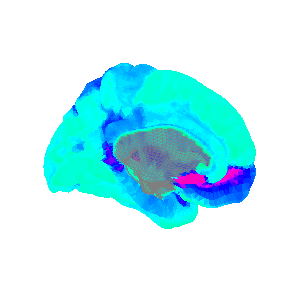

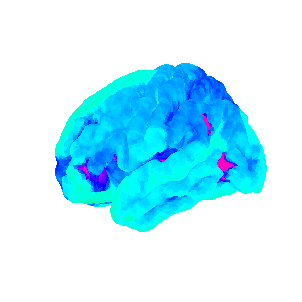

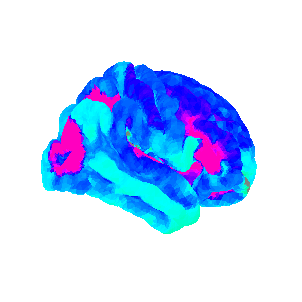

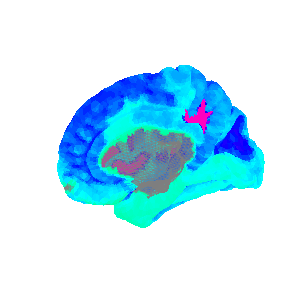

In [52]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_area.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        plotting_arr[np.where(destrieux_vol_arra == i)] = var_df.at[f'{abcd_var}.change_score',
                                                                    ('variance', 'stat')]
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_variance_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_variance_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_variance_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_variance_rightlat.png', dpi=400)

In [53]:
from nilearn import surface

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1418454471.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1418454471.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1418454471.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1418454471.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


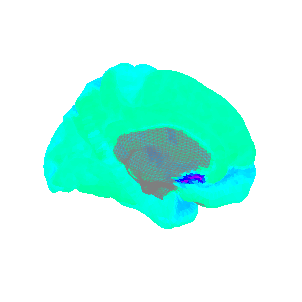

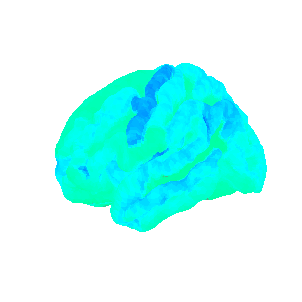

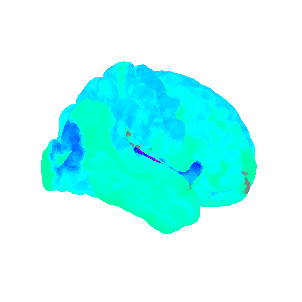

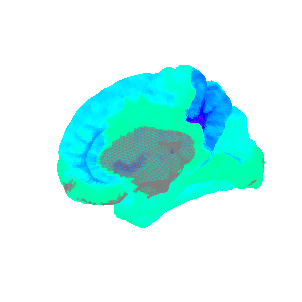

In [54]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        plotting_arr[np.where(destrieux_vol_arra == i)] = var_df.at[f'{abcd_var}.change_score',
                                                                    ('variance', 'stat')]
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_variance_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_variance_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='medial', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_variance_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False,
                                     cmap='gist_rainbow', view='lateral', threshold=1, colorbar=False, vmax=30)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_variance_rightlat.png', dpi=400)

In [55]:
sex_fligner_df = var_df[var_df[('fligner_sex', 'p')] < 0.01][('fligner_sex', 'diff')]

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/824057043.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/824057043.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/824057043.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/824057043.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


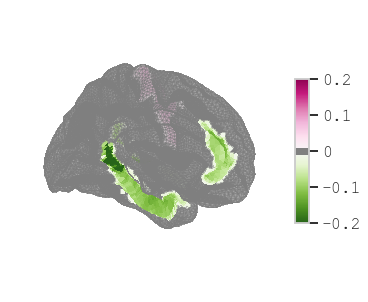

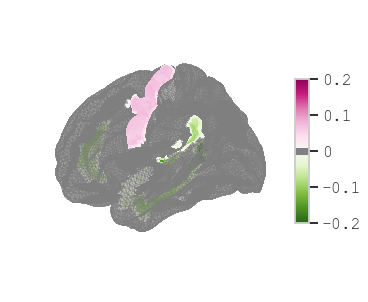

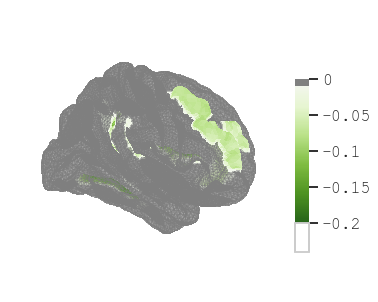

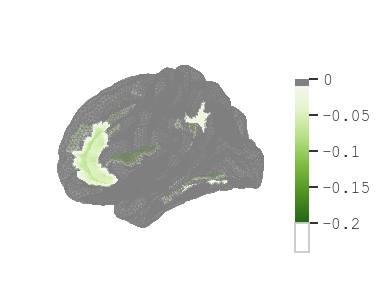

In [56]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = sex_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_sexdifffligner_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_sexdifffligner_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_sexdifffligner_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_sexdifffligner_rightlat.png', dpi=400)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1730302792.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1730302792.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1730302792.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2346/1730302792.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=2)


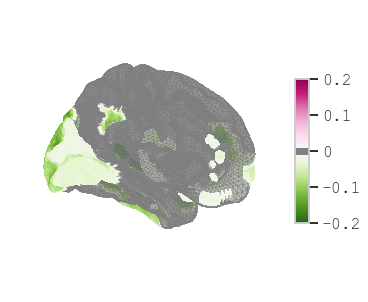

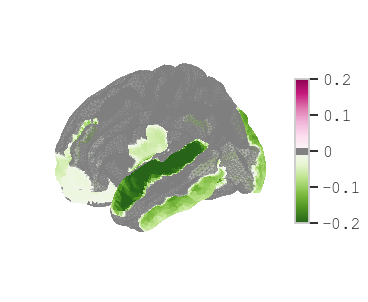

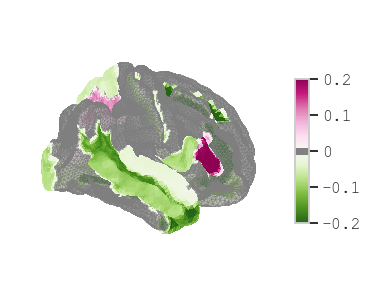

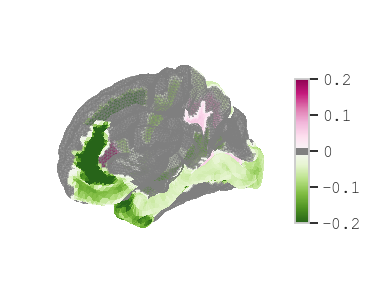

In [57]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    plotted_vars.append(f'{abcd_var}.change_score')
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = sex_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_sexdifffligner_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_sexdifffligner_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='medial', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_sexdifffligner_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r,  vmax=0.2,
                                     cmap='PiYG_r', view='lateral', threshold=0.01, colorbar=True)
plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_sexdifffligner_rightlat.png', dpi=400)

In [58]:
changes = []
for i in abcd_to_harvox['T1w Intensity'].unique()[1:]:
    changes.append(f'{i}.change_score')

In [59]:
var_df.loc[changes]

variance fligner_sex            \
                                          stat        stat         p   
smri_t1w_scs_tplh.change_score        0.520328    1.202798  0.272763   
smri_t1w_scs_caudatelh.change_score   0.864866    0.469886   0.49304   
smri_t1w_scs_putamenlh.change_score   0.448623    4.991762  0.025468   
smri_t1w_scs_pallidumlh.change_score  0.539621    2.898433  0.088666   
smri_t1w_scs_bstem.change_score       0.044225    1.320898  0.250431   
smri_t1w_scs_hpuslh.change_score      0.943657    1.976312   0.15978   
smri_t1w_scs_amygdalalh.change_score  1.970362    1.385574  0.239154   
smri_t1w_scs_aal.change_score         1.381725    2.104095  0.146905   
smri_t1w_scs_tprh.change_score        0.472136    0.393165   0.53064   
smri_t1w_scs_caudaterh.change_score   0.756525    0.045103  0.831814   
smri_t1w_scs_putamenrh.change_score   0.462059    0.001257  0.971716   
smri_t1w_scs_pallidumrh.change_score  0.419215     1.80479  0.179134   
smri_t1w_scs_hpusrh.change_score       0.88172    0.782586  0.376351   
smri_t1w_scs_amygdalarh.change_score  1.601398    2.713394  0.099509   
smri_t1w_scs_aar.change_score         1.058681    1.862001  0.172394   

                                                               \
                                          diff greater a<0.05   
smri_t1w_scs_tplh.change_score        0.022891       f     ns   
smri_t1w_scs_caudatelh.change_score  -0.023213       f     ns   
smri_t1w_scs_putamenlh.change_score   0.093842       f     **   
smri_t1w_scs_pallidumlh.change_score  0.070916       f     ns   
smri_t1w_scs_bstem.change_score       0.012335       f     ns   
smri_t1w_scs_hpuslh.change_score     -0.016537       f     ns   
smri_t1w_scs_amygdalalh.change_score -0.017812       f     ns   
smri_t1w_scs_aal.change_score        -0.004649       f     ns   
smri_t1w_scs_tprh.change_score        0.046978       f     ns   
smri_t1w_scs_caudaterh.change_score   -0.01231       f     ns   
smri_t1w_scs_putamenrh.change_score   0.088723       f     ns   
smri_t1w_scs_pallidumrh.change_score  0.038088       f     ns   
smri_t1w_scs_hpusrh.change_score      0.006311       f     ns   
smri_t1w_scs_amygdalarh.change_score   0.00609       f     ns   
smri_t1w_scs_aar.change_score        -0.005215       f     ns   

                                     fligner_puberty_m                      \
                                                  stat         p      diff   
smri_t1w_scs_tplh.change_score                0.044086  0.978198  0.061646   
smri_t1w_scs_caudatelh.change_score           7.661654  0.021692  0.031749   
smri_t1w_scs_putamenlh.change_score           0.106964  0.947923   0.02511   
smri_t1w_scs_pallidumlh.change_score          2.047367  0.359269  0.031122   
smri_t1w_scs_bstem.change_score                6.20648  0.044903  0.029916   
smri_t1w_scs_hpuslh.change_score              1.097021   0.57781  0.121864   
smri_t1w_scs_amygdalalh.change_score          7.606184  0.022302  0.104195   
smri_t1w_scs_aal.change_score                 5.705758  0.057678  0.021069   
smri_t1w_scs_tprh.change_score                1.195672  0.550001  0.039409   
smri_t1w_scs_caudaterh.change_score           4.662264  0.097186  0.106504   
smri_t1w_scs_putamenrh.change_score           2.924417  0.231724  0.023672   
smri_t1w_scs_pallidumrh.change_score          0.157117  0.924448   0.07802   
smri_t1w_scs_hpusrh.change_score              0.754618  0.685704  0.100577   
smri_t1w_scs_amygdalarh.change_score          5.986289   0.05013  0.057399   
smri_t1w_scs_aar.change_score                 3.831924    0.1472  0.099716   

                                                   ... fligner_marital  \
                                          greater  ...            stat   
smri_t1w_scs_tplh.change_score        [[3, 2, 1]]  ...        4.307376   
smri_t1w_scs_caudatelh.change_score   [[2, 3, 1]]  ...       13.011856   
smri_t1w_scs_putamenlh.change_score   [[1, 3, 2]]  ...       10.935857   
smri_t1w_s

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/plotting/displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


<Figure size 432x288 with 0 Axes>

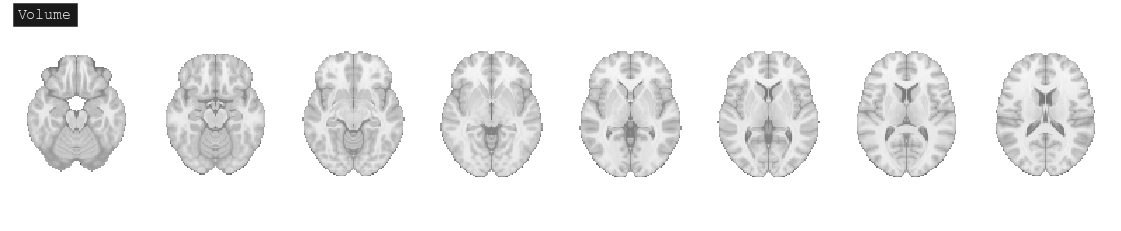

<Figure size 432x288 with 0 Axes>

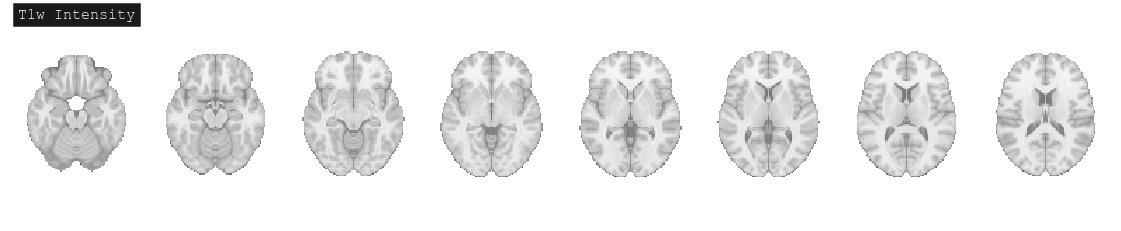

<Figure size 432x288 with 0 Axes>

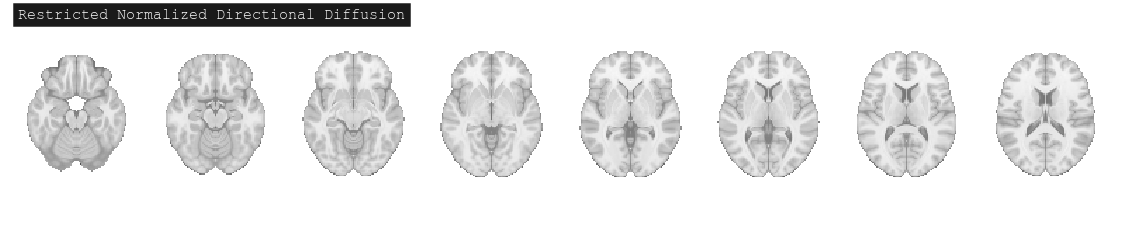

<Figure size 432x288 with 0 Axes>

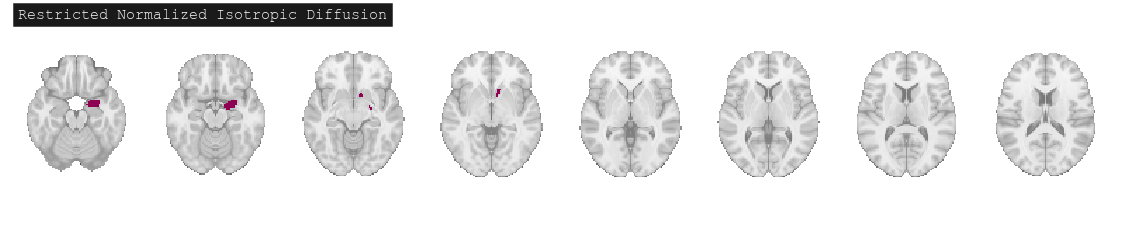

In [60]:
for column in abcd_to_harvox.columns[1:]:
    plotting_arr = np.zeros(sc_array.shape)
    for i in abcd_to_harvox.index:
        abcd_var = abcd_to_harvox.loc[i, column]
        if column == 'Volume':
            plotted_vars.append(f'{abcd_var}.change_score')
        else:
            pass
        if abcd_var is np.nan:
            pass
        else:
            try:
                plotting_arr[np.where(sc_array == i)] = sex_fligner_df.loc[f'{abcd_var}.change_score']
            except:
                plotting_arr[np.where(sc_array == i)] = 0
    smri_vol_var_nimg = nib.Nifti1Image(plotting_arr, subcort.filename.affine)
    grid_kw = dict(width_ratios=[10,1])
    plt.figure(layout='tight')
    fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
    q = plotting.plot_stat_map(smri_vol_var_nimg, display_mode='z', 
                           cut_coords=[-20, -15, -10, -5, 0, 5, 10, 15], 
                           annotate=False, cmap='PiYG_r', colorbar=False, title=column,
                           vmax=0.2, symmetric_cbar=False, threshold=0.1, axes=ax[0])

    ax[1].set_visible(False)
    q.savefig(f'../figures/{column}_sexdifffligner.png', dpi=400)

In [61]:
plotted_vars = list(np.unique(plotted_vars))
try:
    plotted_vars.remove('nan.change_score')
except Exception as e:
    pass

In [62]:
pvar_f = pd.DataFrame(index=plotted_vars, 
                    columns=['highest', 
                             'middle', 
                             'lowest'])

for i in pvar_f.index:
    pvar_f.at[i, 'highest'] = int(var_df.loc[i, ('fligner_puberty_f', 'greater')][0][0])
    pvar_f.at[i, 'middle'] = int(var_df.loc[i, ('fligner_puberty_f', 'greater')][0][1])
    pvar_f.at[i, 'lowest'] = int(var_df.loc[i, ('fligner_puberty_f', 'greater')][0][2])

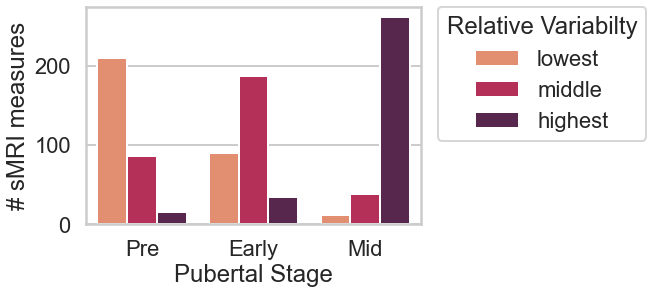

In [63]:
sns.set_style('whitegrid')
sns.set_context('poster')
fig,ax = plt.subplots()
sns.countplot(x='value', hue='variable', 
              hue_order=['lowest', 'middle', 'highest'], 
              data=pd.melt(pvar_f), palette='rocket_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Relative Variabilty')
ax.set_xticklabels(['Pre', 'Early', 'Mid'])
ax.set_xlabel('Pubertal Stage')
ax.set_ylabel('# sMRI measures')
fig.savefig('../figures/pubertal_variability_f.png', dpi=400, bbox_inches='tight')

In [64]:
pvar_m = pd.DataFrame(index=plotted_vars, 
                    columns=['highest', 
                             'middle', 
                             'lowest'])

for i in pvar_m.index:
    pvar_m.at[i, 'highest'] = int(var_df.loc[i, ('fligner_puberty_m', 'greater')][0][0])
    pvar_m.at[i, 'middle'] = int(var_df.loc[i, ('fligner_puberty_m', 'greater')][0][1])
    pvar_m.at[i, 'lowest'] = int(var_df.loc[i, ('fligner_puberty_m', 'greater')][0][2])

In [65]:
np.sum(pvar_m['lowest'] == 1)

119

In [76]:
from statsmodels.stats import contingency_tables
contingency = np.zeros((3,3))
contingency[0][0] = np.sum(pvar_m['lowest'] == 1)
contingency[0][1] = np.sum(pvar_m['middle'] == 1)
contingency[0][2] = np.sum(pvar_m['highest'] == 1)
contingency[1][0] = np.sum(pvar_m['lowest'] == 2)
contingency[1][1] = np.sum(pvar_m['middle'] == 2)
contingency[1][2] = np.sum(pvar_m['highest'] == 2)
contingency[2][0] = np.sum(pvar_m['lowest'] == 3)
contingency[2][1] = np.sum(pvar_m['middle'] == 3)
contingency[2][2] = np.sum(pvar_m['highest'] == 3)
m_by_puberty_diff = contingency_tables.cochrans_q(contingency.T) 
print(contingency, '\n\n', m_by_puberty_diff)

[[119. 114.  78.]
 [ 85. 151.  75.]
 [107.  46. 158.]] 

 df          2
pvalue      0.36787944117144245
statistic   2.0


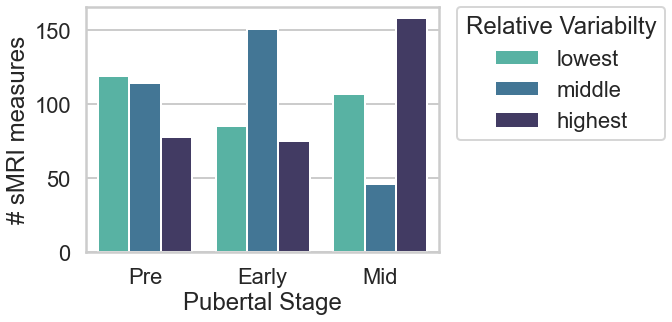

In [68]:
sns.set_style('whitegrid')
sns.set_context('poster')
fig,ax = plt.subplots(figsize=(10,5))
sns.countplot(x='value', hue='variable', 
              hue_order=['lowest', 'middle', 'highest'], 
              data=pd.melt(pvar_m), palette='mako_r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Relative Variabilty')
ax.set_xticklabels(['Pre', 'Early', 'Mid'])
ax.set_xlabel('Pubertal Stage')
ax.set_ylabel('# sMRI measures')
plt.tight_layout()
fig.savefig('../figures/pubertal_variability_m.png', dpi=400, bbox_inches='tight')

In [74]:
contingency = np.zeros((3,3))
contingency[0][0] = np.sum(pvar_f['lowest'] == 1)
contingency[0][1] = np.sum(pvar_f['middle'] == 1)
contingency[0][2] = np.sum(pvar_f['highest'] == 1)
contingency[1][0] = np.sum(pvar_f['lowest'] == 2)
contingency[1][1] = np.sum(pvar_f['middle'] == 2)
contingency[1][2] = np.sum(pvar_f['highest'] == 2)
contingency[2][0] = np.sum(pvar_f['lowest'] == 3)
contingency[2][1] = np.sum(pvar_f['middle'] == 3)
contingency[2][2] = np.sum(pvar_f['highest'] == 3)
f_by_puberty_diff = contingency_tables.cochrans_q(contingency) 
print(contingency, '\n\n', f_by_puberty_diff)

[[209.  86.  16.]
 [ 90. 187.  34.]
 [ 12.  38. 261.]] 

 df          2
pvalue      0.36787944117144245
statistic   2.0


In [ ]:
fpu_fligner_df = var_df[var_df[('fligner_puberty_f', 'p')] < 0.01][('fligner_puberty_f', 'diff')]
mpu_fligner_df = var_df[var_df[('fligner_puberty_m', 'p')] < 0.01][('fligner_puberty_m', 'diff')]

In [91]:
np.unique(destrieux_vol_arra).shape

(149,)

In [102]:
atlas_to_abcd_thick.to_csv('destrieux_to_abcd_thickness.csv')

In [ ]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = fpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydifff_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydifff_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydifff_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydifff_rightlat.png', dpi=400)

In [ ]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = fpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydifff_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydifff_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydifff_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='magma', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydifff_rightlat.png', dpi=400)

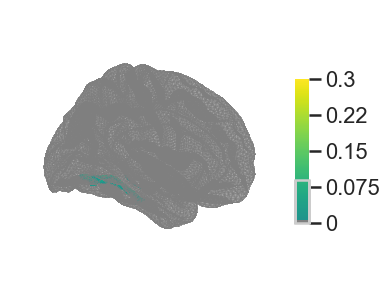

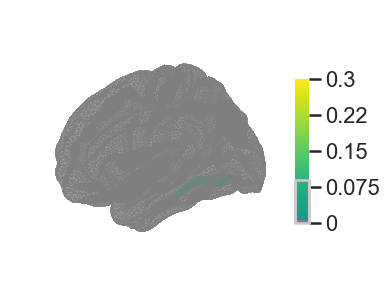

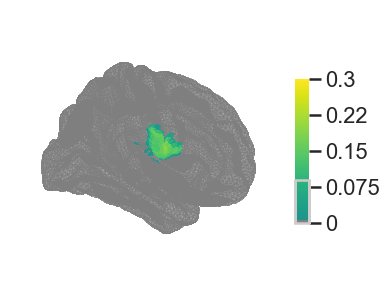

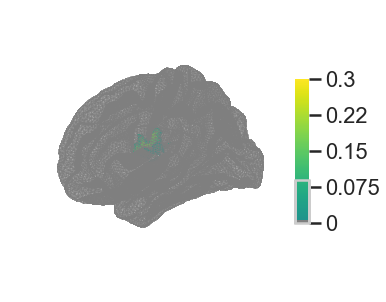

In [112]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_thick.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = mpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_thick_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_thick_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydiffm_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydiffm_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydiffm_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_thickness_pubertydiffm_rightlat.png', dpi=400)

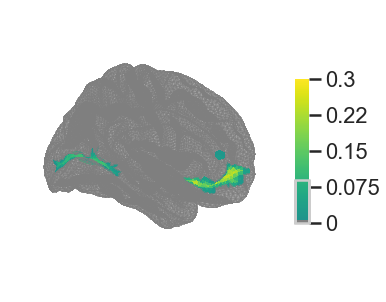

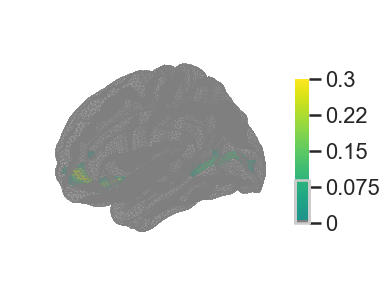

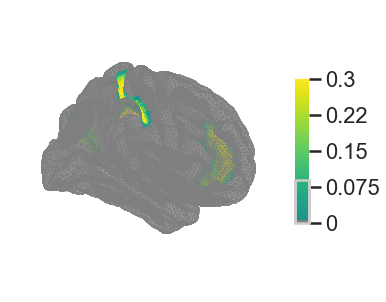

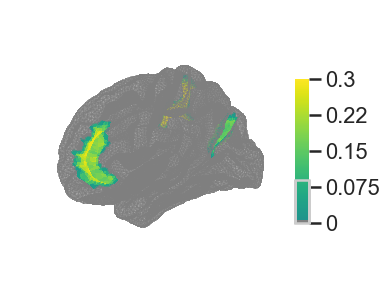

In [113]:
plotting_arr = np.zeros(destrieux_vol_arra.shape)
for i in atlas_to_abcd_thick.index:
    abcd_var = atlas_to_abcd_area.loc[i, 'abcd_var']
    if abcd_var is np.nan:
        pass
    else:
        try:
            plotting_arr[np.where(destrieux_vol_arra == i)] = mpu_fligner_df.loc[f'{abcd_var}.change_score']
        except:
            plotting_arr[np.where(destrieux_vol_arra == i)] = 0
smri_area_var_nimg = nib.Nifti1Image(plotting_arr, destrieux_vol_nimg.affine)

texture_l = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_left, interpolation='nearest')
texture_r = surface.vol_to_surf(smri_area_var_nimg, fsaverage.pial_right, interpolation='nearest')

figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydiffm_leftmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydiffm_leftlat.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='medial', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydiffm_rightmed.png', dpi=400)
figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, vmax=0.3,
                                     cmap='viridis', view='lateral', threshold=0.01, colorbar=True)
#plt.tight_layout(pad=2)
figure.savefig('../figures/cortical_area_pubertydiffm_rightlat.png', dpi=400)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_38928/2494460943.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal',


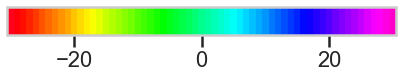

In [114]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap='gist_rainbow', 
                               values=range(-30,31), )

plt.savefig('../figures/gist_rainbow.png', bbox_inches='tight', dpi=400)

In [124]:
img_modalities['fmri'].std().sort_values().iloc[-20:]

rsfmri_cor_ngd_df_scs_crcxlh.change_score     3.737895e+04
rsfmri_cor_ngd_sa_scs_thplh.change_score      3.762902e+04
rsfmri_cor_ngd_df_scs_thprh.change_score      4.131973e+04
rsfmri_c_ngd_smh_ngd_vta.change_score         4.264233e+04
rsfmri_cor_ngd_vs_scs_hplh.change_score       4.348910e+04
rsfmri_cor_ngd_dsa_scs_agrh.change_score      4.416402e+04
rsfmri_c_ngd_cgc_ngd_fo.change_score          4.643091e+04
rsfmri_cor_ngd_rst_scs_hplh.change_score      4.675725e+04
rsfmri_cor_ngd_df_scs_vtdcrh.change_score     4.676842e+04
rsfmri_c_ngd_ca_ngd_sa.change_score           4.702333e+04
rsfmri_cor_ngd_fopa_scs_agrh.change_score     6.244225e+04
rsfmri_c_ngd_ad_ngd_n.change_score            7.287826e+04
rsfmri_cor_ngd_dsa_scs_thplh.change_score     8.040616e+04
rsfmri_cor_ngd_smh_scs_cdelh.change_score     8.543589e+04
rsfmri_cor_ngd_cerc_scs_plrh.change_score     9.583803e+04
rsfmri_c_ngd_ca_ngd_smm.change_score          1.015467e+05
rsfmri_cor_ngd_rst_scs_thprh.change_score     2.189144e+

<AxesSubplot:xlabel='rsfmri_cor_ngd_dsa_scs_cderh.2_year_follow_up_y_arm_1', ylabel='Density'>

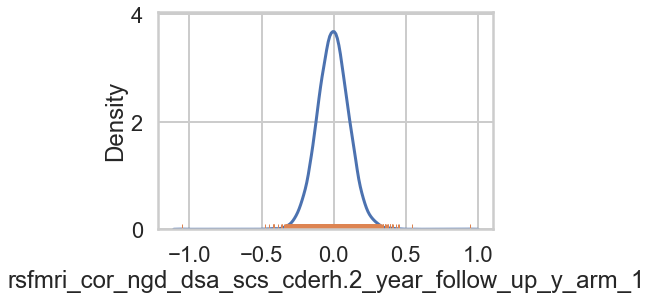

In [134]:
fig,ax = plt.subplots()
sns.kdeplot(df['rsfmri_cor_ngd_dsa_scs_cderh.2_year_follow_up_y_arm_1'])
sns.rugplot(df['rsfmri_cor_ngd_dsa_scs_cderh.2_year_follow_up_y_arm_1'])
#ax.set_xscale('log')

In [143]:
base = abs(df['rsfmri_cor_ngd_dsa_scs_cderh.2_year_follow_up_y_arm_1'])
y2fu = abs(df['rsfmri_cor_ngd_dsa_scs_cderh.baseline_year_1_arm_1'])
age0 = df['interview_age.baseline_year_1_arm_1'] / 12
age2 = df['interview_age.2_year_follow_up_y_arm_1'] / 12
change_scores = (((y2fu - base) / ((y2fu + base) / 2)) * 100) / (age2 - age0)

51.43096411444154

In [117]:
# correlate baseline values and change scores
df

,imgincl_dmri_include.baseline_year_1_arm_1,imgincl_dmri_include.2_year_follow_up_y_arm_1,imgincl_rsfmri_include.baseline_year_1_arm_1,imgincl_rsfmri_include.2_year_follow_up_y_arm_1,imgincl_t1w_include.baseline_year_1_arm_1,imgincl_t1w_include.2_year_follow_up_y_arm_1,imgincl_t2w_include.baseline_year_1_arm_1,imgincl_t2w_include.2_year_follow_up_y_arm_1,interview_age.baseline_year_1_arm_1,interview_age.2_year_follow_up_y_arm_1,...,demo_prnt_ed_v2.baseline_year_1_arm_1,demo_prnt_ed_v2.2_year_follow_up_y_arm_1,demo_comb_income_v2.baseline_year_1_arm_1,demo_comb_income_v2.2_year_follow_up_y_arm_1,pds_p_ss_female_category_2.baseline_year_1_arm_1,pds_p_ss_female_category_2.2_year_follow_up_y_arm_1,pds_p_ss_male_category_2.baseline_year_1_arm_1,pds_p_ss_male_category_2.2_year_follow_up_y_arm_1,sex.baseline_year_1_arm_1,sex.2_year_follow_up_y_arm_1
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INV022ZVCT8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,116.0,139.0,...,18,NaN,8.0,NaN,1.0,3.0,NaN,NaN,F,F
NDAR_INV08J0E48V,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,126.0,158.0,...,18,NaN,9.0,NaN,1.0,4.0,NaN,NaN,F,F
NDAR_INV08K0R9C4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,127.0,153.0,...,18,NaN,7.0,NaN,NaN,NaN,1.0,3.0,M,M
NDAR_INV08P3GNDV,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,119.0,141.0,...,19,NaN,9.0,NaN,2.0,3.0,NaN,NaN,F,F
NDAR_INV08R2PTT1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,130.0,153.0,...,18,NaN,9.0,NaN,NaN,NaN,2.0,4.0,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVZTPV9V4Z,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,124.0,153.0,...,19,NaN,8.0,NaN,1.0,3.0,NaN,NaN,F,F
NDAR_INVZN4F9J96,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,110.0,139.0,...,14,NaN,7.0,NaN,NaN,NaN,1.0,1.0,M,M
NDAR_INVZPRTF377,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,115.0,141.0,...,18,NaN,1.0,NaN,3.0,4.0,NaN,NaN,F,F
